In [55]:
import xml
import xml.etree.ElementTree as ET
import os
from os import path
import glob
from collections import defaultdict
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image


### Setting up path related information

In [56]:
base_data_dir = "/home/shtoshni/Research/events/data/kbp_2014-2015/data/2015"
output_dir = "/home/shtoshni/Research/events/data/kbp_2014-2015/"

split_to_subdir_dict = {
    "training": {"source": "source", "mention": "event_nugget", "coref": "event_hopper"},
    "eval": {"source": "source", "mention": "nugget", "coref": "hopper"}
}

file_suffix = {"mention": ".event_nuggets.xml", "coref": ".event_hoppers.xml"}

### Set split to "training"

In [64]:
SPLIT = 'training'
split_dir = path.join(base_data_dir, SPLIT)
subdir_dict = split_to_subdir_dict[SPLIT]

### Mention stats

In [65]:
# Get all mention files
mention_dir = path.join(split_dir, subdir_dict["mention"])
mention_ann_files = sorted(glob.glob(path.join(mention_dir, "*.xml")))

# Global counters
doc_types = defaultdict(int)
event_type_count = defaultdict(int)
event_subtype_count = defaultdict(int)
event_realis_count = defaultdict(int)
trigger_word_dict = defaultdict(int)
span_to_count = defaultdict(set)
problematic_anns = 0

for ann_file in mention_ann_files:
    tree = ET.parse(ann_file)
    xml_root = tree.getroot()

    doc_id = xml_root.attrib['doc_id']
    doc_source_type = xml_root.attrib['source_type']
    
    # Update doc type count
    doc_types[doc_source_type] += 1

    for elem in xml_root.iter('event_mention'):
        event_id = elem.attrib['id']
        event_type = elem.attrib['type']
        # Update event type count
        event_type_count[event_type] += 1
        
        event_subtype = f"{event_type}.{elem.attrib['subtype']}"
        # Update event subtype count
        event_subtype_count[event_subtype] += 1
        
        event_realis = elem.attrib['realis']
        event_realis_count[event_realis] += 1
        
        trigger_elem = elem.find('trigger')
        offset = trigger_elem.attrib['offset']
        length = trigger_elem.attrib['length']
        event_phrase = trigger_elem.text
        trigger_word_dict[event_phrase] += 1
        
        # Doc ID, doc offset, and span length uniquely identify a span 
        if (event_subtype, event_realis) in span_to_count[(doc_id, offset, length)]:
            problematic_anns += 1
            print(doc_id, event_phrase, offset, length)
        span_to_count[(doc_id, offset, length)].add((event_subtype, event_realis))
        
    
print ("\n Total problematic anns:", problematic_anns)
trigger_count_per_span = defaultdict(int)
total_events = 0
for (doc_id, offset, length), event_id_list in span_to_count.items():
    trigger_count_per_span[len(event_id_list)] += 1
    total_events += len(event_id_list)

    

3f71fead3fa119ccdcdf01769ffee5b1 sentenced 1052 9
3f71fead3fa119ccdcdf01769ffee5b1 charged 3165 7
APW_ENG_20090829.0063 former 836 6
APW_ENG_20090829.0063 worked 882 6
APW_ENG_20090829.0063 worked 882 6
CNA_ENG_20101001.0032 charges 446 7
bolt-eng-DF-170-181118-8874957 pay 1352 3

 Total problematic anns: 7


### Plot mention stats

Doc types: ('multi_post', 'newswire')
Event types: ('business', 'conflict', 'contact', 'justice', 'life', 'manufacture', 'movement', 'personnel', 'transaction')
Event Subtypes: ('business.declarebankruptcy', 'business.endorg', 'business.mergeorg', 'business.startorg', 'conflict.attack', 'conflict.demonstrate', 'contact.broadcast', 'contact.contact', 'contact.correspondence', 'contact.meet', 'justice.acquit', 'justice.appeal', 'justice.arrestjail', 'justice.chargeindict', 'justice.convict', 'justice.execute', 'justice.extradite', 'justice.fine', 'justice.pardon', 'justice.releaseparole', 'justice.sentence', 'justice.sue', 'justice.trialhearing', 'life.beborn', 'life.die', 'life.divorce', 'life.injure', 'life.marry', 'manufacture.artifact', 'movement.transportartifact', 'movement.transportperson', 'personnel.elect', 'personnel.endposition', 'personnel.nominate', 'personnel.startposition', 'transaction.transaction', 'transaction.transfermoney', 'transaction.transferownership')


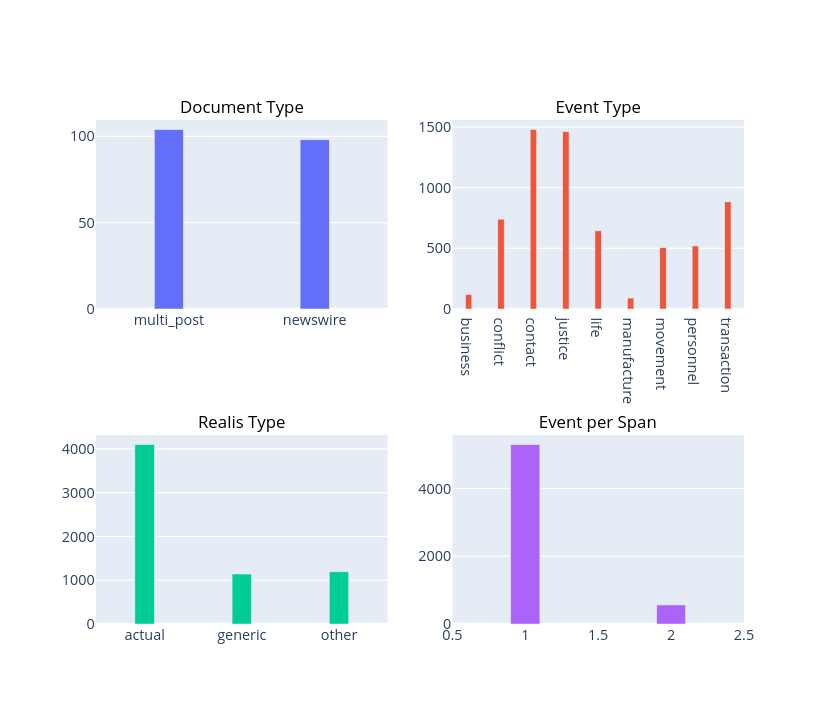

In [59]:
fig = make_subplots(rows=2, cols=2, 
                   subplot_titles=("Document Type", "Event Type", "Realis Type", "Event per Span"))


x, y = zip(*sorted(doc_types.items()))
fig.add_trace(
    go.Bar(x=x, y=y, width=0.2),
    row=1, col=1
)
print("Doc types:", x)

x, y = zip(*sorted(event_type_count.items()))
fig.add_trace(
    go.Bar(x=x, y=y, width=0.2),
    row=1, col=2
)
print("Event types:", x)

x, y = zip(*sorted(event_subtype_count.items()))
print("Event Subtypes:", x)


x, y = zip(*sorted(event_realis_count.items()))
fig.add_trace(
    go.Bar(x=x, y=y, width=0.2),
    row=2, col=1
)

x, y = zip(*sorted(trigger_count_per_span.items()))
x = [str(x_elem) for x_elem in x]  # The X-labels need to be a string
fig.add_trace(
    go.Bar(x=x, y=y, width=0.2),
    row=2, col=2
)

for ann in fig['layout']['annotations']:
    ann['font'] = dict(size=14,color='#000000')

fig.update_layout(showlegend=False)
# fig.show()

img_bytes = fig.to_image(format="png", width=700, height=600, scale=1.2)
Image(img_bytes)


### Other Mention Stats

In [60]:
print (f"Total events: {total_events}\n")

K = 10

# Subtype counts
subtype_counts = sorted(event_subtype_count.items(), key=lambda x: x[1], reverse=True)
print(f'Top-{K} event subtypes (out of {len(event_subtype_count)})\n')
for subtype, count in subtype_counts[:K]:
    print(subtype, count)

print('\n')

# Trigger words
trigger_word_counts = sorted(trigger_word_dict.items(), key=lambda x: x[1], reverse=True)
print(f'Top-{K} event triggers (out of {len(trigger_word_dict)})\n')
for trigger_word, count in trigger_word_counts[:K]:
    print(trigger_word, count)


Total events: 6426

Top-10 event subtypes (out of 38)

conflict.attack 591
contact.contact 587
transaction.transfermoney 554
contact.broadcast 510
movement.transportperson 439
life.die 408
justice.arrestjail 348
personnel.endposition 291
contact.meet 272
transaction.transferownership 265


Top-10 event triggers (out of 1594)

said 287
former 102
death 98
murder 89
prison 83
charges 69
killed 67
extradition 64
statement 61
trial 57


### Coref Stats

In [61]:
# Get all mention files
coref_dir = path.join(split_dir, subdir_dict["coref"])
coref_ann_files = sorted(glob.glob(path.join(coref_dir, "*.xml")))

# Global counters
event_type_counter = defaultdict(int)
event_subtype_counter = defaultdict(int)
event_realis_counter = defaultdict(int)
event_phrase_counter = defaultdict(int)
coref_chain_size_counter = defaultdict(int)

for ann_file in coref_ann_files:
    tree = ET.parse(ann_file)
    xml_root = tree.getroot()
    
    for coref_elem in xml_root.iter('hopper'):
        event_type_set = set()
        event_subtype_set = set()
        event_realis_set = set()
        event_phrase_set = set()
        coref_chain_size = 0
        for event_elem in coref_elem.iter('event_mention'):
            # Get type, subtype, realis, and text
            event_type_set.add(event_elem.attrib['type'])
            event_subtype_set.add(f"{event_type}.{event_elem.attrib['subtype']}")
            event_realis_set.add(event_elem.attrib['realis'])

            trigger_elem = event_elem.find('trigger')
            event_phrase_set.add(trigger_elem.text)
            coref_chain_size += 1
            
        event_type_counter[len(event_type_set)] += 1
        event_subtype_counter[len(event_subtype_set)] += 1
        event_realis_counter[len(event_realis_set)] += 1
        event_phrase_counter[len(event_phrase_set)] += 1
        coref_chain_size_counter[coref_chain_size] += 1

### Plot Coref Chain Stats

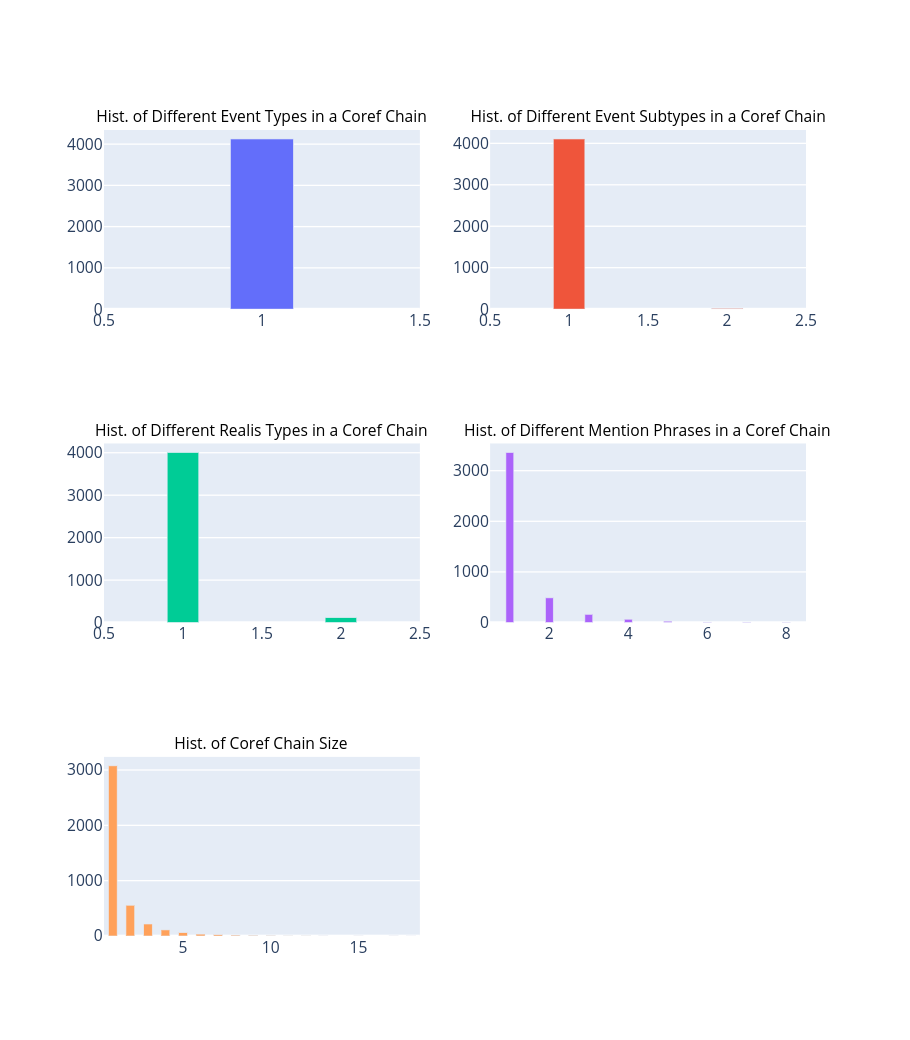

In [62]:
fig = make_subplots(rows=3, cols=2, 
                   subplot_titles=("Hist. of Different Event Types in a Coref Chain", 
                                   "Hist. of Different Event Subtypes in a Coref Chain", 
                                   "Hist. of Different Realis Types in a Coref Chain", 
                                   "Hist. of Different Mention Phrases in a Coref Chain",
                                   "Hist. of Coref Chain Size",
                                  )
                   )


x, y = zip(*sorted(event_type_counter.items()))
fig.add_trace(
    go.Bar(x=x, y=y, width=0.2),
    row=1, col=1
)

x, y = zip(*sorted(event_subtype_counter.items()))
fig.add_trace(
    go.Bar(x=x, y=y, width=0.2),
    row=1, col=2
)

x, y = zip(*sorted(event_realis_counter.items()))
fig.add_trace(
    go.Bar(x=x, y=y, width=0.2),
    row=2, col=1
)

x, y = zip(*sorted(event_phrase_counter.items()))
fig.add_trace(
    go.Bar(x=x, y=y, width=0.2),
    row=2, col=2
)
                    
x, y = zip(*sorted(coref_chain_size_counter.items()))
fig.add_trace(
    go.Bar(x=x, y=y, width=0.5),
    row=3, col=1
)                   

for ann in fig['layout']['annotations']:
    ann['font'] = dict(size=12,color='#000000')

fig.update_layout(showlegend=False)
# fig.show()

img_bytes = fig.to_image(format="png", width=700, height=800, scale=1.3)
Image(img_bytes)
